# Lab 5-1 Data Augmentation

- Mingyang Zhao, 1545421
- Ta-Nien Chiang, 1270750

In this lab, you will develop a data augmentation and visualization.

First, generate the dataset we need

In [3]:
# ============
# dependencies
# ============

import glob
import os
import random
import shutil

from matplotlib import pyplot as plt
from matplotlib.image import imread

# ==========================
# Download and unzip dataset
# ==========================

DATASET_PATH = "/content/"
# FILE_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# FILE_URL = "http://files.fast.ai/data/dogscats.zip"
FILE_URL = "https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip"

ZIP_FILE = "/content/dogs-vs-cats.zip"

if not os.path.exists("dogs-vs-cats.zip"):
    # Clean /content/
    !cd /content && rm -rf *

    # download
    !wget --no-check-certificate \
        $FILE_URL \
        -O $ZIP_FILE

    # unzip
    !unzip -qq $ZIP_FILE
    !mv Cat_Dog_data dogs-vs-cats

# =======================
# Generate sample dataset
# =======================

NSAMPLES = 3000

dataset_dir = "dogs-vs-cats"

train_dir = dataset_dir + "/train"

train_dogs = glob.glob(f"{dataset_dir}/train/dog" + "/dog*.*")
train_cats = glob.glob(f"{dataset_dir}/train/cat" + "/cat*.*")

sampled_train_dir = dataset_dir + "/s_train"
sampled_valid_dir = dataset_dir + "/s_valid"
sampled_test_dir = dataset_dir + "/s_test"

if not os.path.exists(f"{sampled_test_dir}/dogs") or \
  len(os.listdir(f"{sampled_test_dir}/dogs")) != NSAMPLES:
  try:
      shutil.rmtree(sampled_train_dir)
      shutil.rmtree(sampled_valid_dir)
      shutil.rmtree(sampled_test_dir)
  except:
      pass

  os.mkdir(sampled_train_dir)
  os.mkdir(sampled_valid_dir)
  os.mkdir(sampled_test_dir)

  os.mkdir(sampled_train_dir + "/dogs")
  os.mkdir(sampled_train_dir + "/cats")

  os.mkdir(sampled_valid_dir + "/dogs")
  os.mkdir(sampled_valid_dir + "/cats")

  os.mkdir(sampled_test_dir + "/dogs")
  os.mkdir(sampled_test_dir + "/cats")

  random.shuffle(train_dogs)
  random.shuffle(train_cats)

  for fn in train_dogs[0:NSAMPLES]:
      src = fn
      dst = sampled_train_dir + "/dogs/" + os.path.split(src)[-1]
      shutil.copyfile(src, dst)

  for fn in train_cats[0:NSAMPLES]:
      src = fn
      dst = sampled_train_dir + "/cats/" + os.path.split(src)[-1]
      shutil.copyfile(src, dst)

  for fn in train_dogs[NSAMPLES:NSAMPLES + NSAMPLES//2]:
      src = fn
      dst = sampled_valid_dir + "/dogs/" + os.path.split(src)[-1]
      shutil.copyfile(src, dst)

  for fn in train_cats[NSAMPLES:NSAMPLES + NSAMPLES//2]:
      src = fn
      dst = sampled_valid_dir + "/cats/" + os.path.split(src)[-1]
      shutil.copyfile(src, dst)

  for fn in train_dogs[NSAMPLES + NSAMPLES//2: 2 * NSAMPLES]:
      src = fn
      dst = sampled_test_dir + "/dogs/" + os.path.split(src)[-1]
      shutil.copyfile(src, dst)

  for fn in train_cats[NSAMPLES + NSAMPLES//2: 2 * NSAMPLES]:
      src = fn
      dst = sampled_test_dir + "/cats/" + os.path.split(src)[-1]
      shutil.copyfile(src, dst)

--2020-03-02 04:49:18--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.32.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.32.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘/content/dogs-vs-cats.zip’

/content/dogs-vs-ca 100%[===================>] 553.60M  76.3MB/s    in 8.2s    

2020-03-02 04:49:27 (67.2 MB/s) - ‘/content/dogs-vs-cats.zip’ saved [580495262/580495262]



Sample dataset counts
---------------------
s_train (dog/cat): 3000
s_valid (dog/cat): 1500



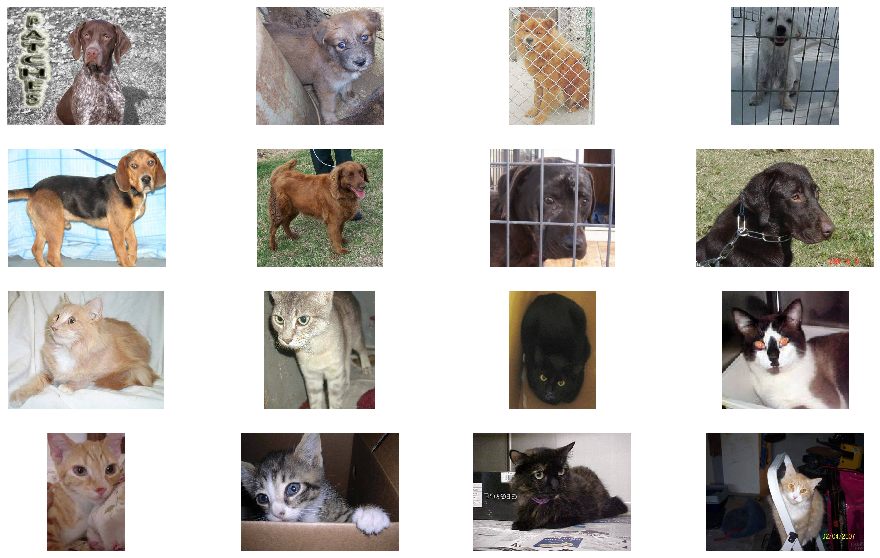

In [0]:
train_count = !ls {sampled_train_dir}/dogs | wc -l
valid_count = !ls {sampled_valid_dir}/dogs | wc -l


print(f"""\
Sample dataset counts
---------------------
s_train (dog/cat): {int(train_count[0])}
s_valid (dog/cat): {int(valid_count[0])}
""")


# ============
# plot samples
# ============

dog_list = os.listdir(f"{sampled_train_dir}/dogs")
cat_list = os.listdir(f"{sampled_train_dir}/cats")
index = [random.choice(range(1000)) for i in range(16)]

fig, axs = plt.subplots(4, 4, figsize=(16, 10))
for row in range(4):
    for col in range(4):
        n = row * 4 + col

        dog_file = f"{sampled_train_dir}/dogs/{dog_list[index[n]]}"
        cat_file = f"{sampled_train_dir}/cats/{cat_list[index[n]]}"

        img = imread(dog_file) if n < 8 else imread(cat_file)
        axs[row][col].imshow(img)
        axs[row][col].axis('off')
        

## Models

In [0]:
%tensorflow_version 2.x

# dependencies

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

# ============
# DL model
# ============

def get_model(model_name, optimizer):

    model_names = (
        "original", 
        "three-block-vgg", 
        "three-block-vgg-dropout", 
        "vgg-transfer", 
        "vgg-preprocess", 
        "vgg-fc-output", 
        "resnet50-transfer", 
        "mobilenet-transfer",
        "vgg-transfer-preprocessed"
    )
    assert model_name in model_names, f"Unknown model_name \"{model_name}\", must be one of {model_names}!"
    
    model = Sequential()

    # == model structures ==

    if model_name == "original":
        model.add(Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(150, 150, 3)))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Flatten())
        model.add(Dropout(0.5))

        model.add(Dense(512, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

    if model_name == "three-block-vgg":
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150, 150, 3)))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Flatten())

        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))

    if model_name == "three-block-vgg-dropout":
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150, 150, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())

        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

    if model_name == "vgg-transfer":
        vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))
        vgg16.trainable = False

        x = Flatten()(vgg16.layers[-1].output)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=vgg16.inputs, outputs=x)

    if model_name == "vgg-preprocess":
        vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))
        vgg16.trainable = False

        x = Flatten()(vgg16.layers[-1].output)

        model = Model(inputs=vgg16.inputs, outputs=x)

    if model_name == "vgg-fc-output":
        x = x_i = Input(shape=(8192))
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=x_i, outputs=x)

    if model_name == "resnet50-transfer":
        res50 = ResNet50(include_top=False, input_shape=(150, 150, 3))
        res50.trainable = False

        x = Flatten()(res50.layers[-1].output)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=res50.inputs, outputs=x)

    if model_name == "mobilenet-transfer":
        mobile_v2 = MobileNetV2(include_top=False, input_shape=(150, 150, 3))
        mobile_v2.trainable = False

        x = Flatten()(mobile_v2.layers[-1].output)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=mobile_v2.inputs, outputs=x)

    if model_name == "vgg-transfer-preprocessed":
        x = x_input = Input(shape=(4, 4, 512))
        x = Flatten()(x)
        x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
        x = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=x_input, outputs=x)

    # compile
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# adam = Adam(lr=0.01)
# model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["acc"])


# ========
# Plotting
# ========

def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    
    if "accuracy" in history.history:
      plt.plot(history.history['accuracy'], color='blue', label='train')
      plt.plot(history.history['val_accuracy'], color='orange', label='test')
    elif "acc" in history.history:
      plt.plot(history.history['acc'], color='blue', label='train')
      plt.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
	# filename = sys.argv[0].split('/')[-1]
	# plt.savefig(filename + '_plot.png')
	# plt.close()

In order for you to look at the generator, lets print the shapes of what it generates.

In [0]:
# for data_batch, labels_batch in train_flow:
#     print("data_batch:", data_batch.shape)
#     print("labels_batch:", labels_batch.shape)
#     break

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =========
# GPU model
# =========

def get_gpu_info():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)


def main(model_name, optimizer, epochs=1):

    # == data prep ==

    # create datagen
    datagen = ImageDataGenerator(rescale=1./255)

    # config datagen
    train_flow = datagen.flow_from_directory(
        sampled_train_dir,
        target_size=(150,150),
        batch_size=64,
        class_mode="binary")

    valid_flow = datagen.flow_from_directory(
        sampled_valid_dir,
        target_size=(150,150),
        batch_size=64,
        class_mode="binary")
    
    # == define model ==

    model = get_model(
        model_name = model_name, 
        optimizer  = optimizer, 
    )
    model.summary()

    # == fit model ==

    history = model.fit_generator(
        train_flow,
        steps_per_epoch = len(train_flow), 
        epochs = epochs,
        validation_data = valid_flow,
        validation_steps = len(valid_flow), 
    )

    # == eval model ==

    _, acc = model.evaluate_generator(valid_flow, steps=len(valid_flow))
    print('> %.3f' % (acc * 100.0))

    # == plotting result ==
    summarize_diagnostics(history)

    return history


Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
______________________________________

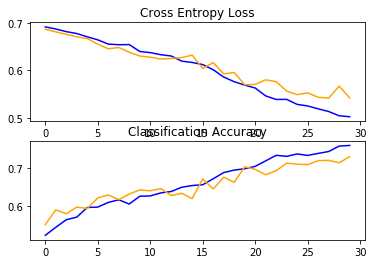

In [0]:
import pickle

# model: original
model_original = main("original", SGD(lr=0.001, momentum=0.9), epochs=30)

with open("model_original", "wb") as f:
    pickle.dump(model_original.history, f)

Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 128)       0         
____________________________________

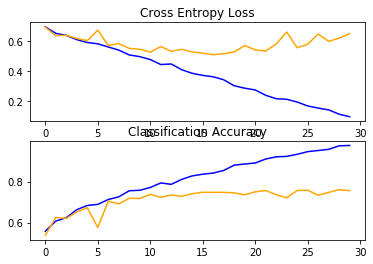

In [0]:
import pickle

# model: three block vgg with SGD, better params initilizaiton
model_3_block_vgg = main("three-block-vgg", SGD(lr=0.001, momentum=0.9), epochs=30)

with open("model_3_block_vgg", "wb") as f:
    pickle.dump(model_3_block_vgg.history, f)

Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 37, 37, 64)        0         
____________________________________

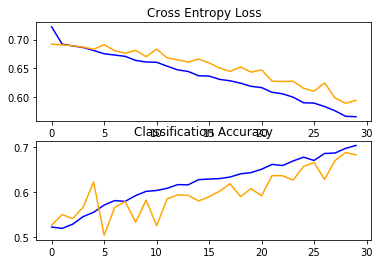

In [0]:
import pickle

# model: three block vgg with SGD, and dropout
model_3_block_vgg_dropout = main("three-block-vgg-dropout", SGD(lr=0.001, momentum=0.9), epochs=30)

with open("model_3_block_vgg_dropout", "wb") as f:
    pickle.dump(model_3_block_vgg_dropout.history, f)

## Augmentation

Not very good for the effort we did. We can try to use data augmentation by rotating, shifting, fliping, and shearing the image.

In [0]:
def main_aug(model_name, optimizer, epochs=1):

    # == data prep ==

    # create seperate datagen
    datagen_train = ImageDataGenerator(rescale=1./255, 
        width_shift_range  = 0.1,
        height_shift_range = 0.1,
        horizontal_flip    = True,
    )
    # datagen_train = ImageDataGenerator(rescale=1./255
    #     rotation_range     = 40, 
    #     width_shift_range  = 0.2,
    #     height_shift_range = 0.2,
    #     shear_range        = 0.2,
    #     zoom_range         = 0.2,
    #     horizontal_flip    = True,
    #     fill_mode          = "nearest"
    # )
    datagen_test = ImageDataGenerator(rescale=1./255)

    # config datagen
    train_flow = datagen_train.flow_from_directory(
        sampled_train_dir,
        target_size=(150,150),
        batch_size=64,
        class_mode="binary")

    valid_flow = datagen_test.flow_from_directory(
        sampled_valid_dir,
        target_size=(150,150),
        batch_size=64,
        class_mode="binary")
    
    # == define model ==

    model = get_model(
        model_name = model_name, 
        optimizer  = optimizer, 
    )
    model.summary()

    # == fit model ==

    history = model.fit_generator(
        train_flow,
        steps_per_epoch = len(train_flow), 
        epochs = epochs,
        validation_data = valid_flow,
        validation_steps = len(valid_flow), 
    )

    # == eval model ==

    _, acc = model.evaluate_generator(valid_flow, steps=len(valid_flow))
    print('> %.3f' % (acc * 100.0))
  
    # == plotting result ==
    summarize_diagnostics(history)

    return history, datagen_train


Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 128)       0         
____________________________________

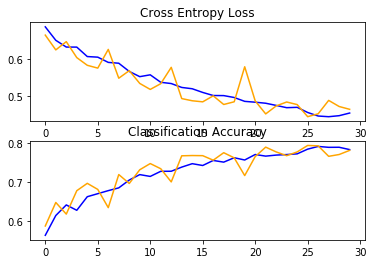

In [0]:
# model: three block vgg with SGD, better params initilizaiton, with augmentation
model_3_block_vgg_aug, datagen_train = main_aug("three-block-vgg", SGD(lr=0.001, momentum=0.9), epochs=30)

with open("model_3_block_vgg_aug", "wb") as f:
    pickle.dump(model_3_block_vgg_aug.history, f)

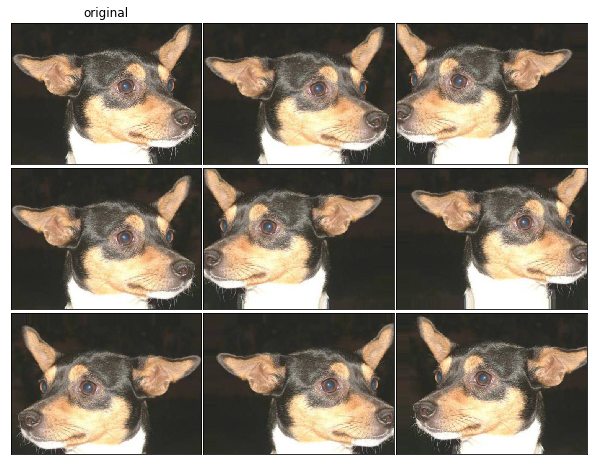

In [0]:
# let's see some of images

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def generate_plot_pics(datagen,orig_img):
    dir_augmented_data = "data/preview"

    if not os.path.isdir("data"):
        os.mkdir("data")
    try:
        ## if the preview folder does not exist, create
        os.mkdir(dir_augmented_data)
    except:
        ## if the preview folder exists, then remove
        ## the contents (pictures) in the folder
        for item in os.listdir(dir_augmented_data):
            os.remove(dir_augmented_data + "/" + item)

    ## convert the original image to array
    x = img_to_array(orig_img)
    ## reshape (Sampke, Nrow, Ncol, 3) 3 = R, G or B
    x = x.reshape((1,) + x.shape)
    ## -------------------------- ##
    ## randomly generate pictures
    ## -------------------------- ##
    i = 0
    Nplot = 8
    for batch in datagen.flow(x,batch_size=1,
                          save_to_dir=dir_augmented_data,
                          save_prefix="pic",
                          save_format='jpeg'):
        i += 1
        if i > Nplot - 1: ## generate 8 pictures 
            break

    ## -------------------------- ##
    ##   plot the generated data
    ## -------------------------- ##
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.02,wspace=0.01,
                    left=0,right=1,bottom=0, top=1)

    ## original picture
    ax = fig.add_subplot(3, 3, 1,xticks=[],yticks=[])        
    ax.imshow(orig_img)
    ax.set_title("original")

    i = 2
    for imgnm in os.listdir(dir_augmented_data):
        ax = fig.add_subplot(3, 3, i,xticks=[],yticks=[]) 
        img = load_img(dir_augmented_data + "/" + imgnm)
        ax.imshow(img)
        i += 1
    plt.show()

img_file = random.choice(train_dogs)
img_ori  = load_img(img_file)

generate_plot_pics(datagen_train, img_ori)

# Transfer Learning

In the second part of this lab, you will load VGG16 and try to get it to improve the result of this model.

## Train from saved VGG16 output

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image as img
import cv2
import numpy as np

In [0]:
sampled_vgg16_train_dir = dataset_dir + "/s_vgg16_train"
sampled_vgg16_valid_dir = dataset_dir + "/s_vgg16_valid"
sampled_vgg16_test_dir = dataset_dir + "/s_vgg16_test"
train_dog_path = os.path.join(sampled_train_dir, "dogs")
train_cat_path = os.path.join(sampled_train_dir, "cats")
valid_dog_path = os.path.join(sampled_valid_dir, "dogs")
valid_cat_path = os.path.join(sampled_valid_dir, "cats")
test_dog_path = os.path.join(sampled_test_dir, "dogs")
test_cat_path = os.path.join(sampled_test_dir, "cats")

def init_vgg_dir():
  print("Init vgg dir...")
  try:
      shutil.rmtree(sampled_vgg16_train_dir)
      shutil.rmtree(sampled_vgg16_valid_dir)
      shutil.rmtree(sampled_vgg16_test_dir)
  except:
      pass

  os.mkdir(sampled_vgg16_train_dir)
  os.mkdir(sampled_vgg16_valid_dir)
  os.mkdir(sampled_vgg16_test_dir)

  os.mkdir(sampled_vgg16_train_dir + "/dogs")
  os.mkdir(sampled_vgg16_train_dir + "/cats")

  os.mkdir(sampled_vgg16_valid_dir + "/dogs")
  os.mkdir(sampled_vgg16_valid_dir + "/cats")

  os.mkdir(sampled_vgg16_test_dir + "/dogs")
  os.mkdir(sampled_vgg16_test_dir + "/cats")

In [0]:
def get_batch_images(path, batch_size):
  i = 0
  batch_images = []
  images = []

  # Read images from file
  for src in path:
    i = i + 1

    image = cv2.imread(src)
    image = cv2.resize(image, (150, 150))
    image = image / 255.0
    images.append(image)

    if i % batch_size == 0:
      batch_images.append(np.array(images))
      images = []

  if len(images) > 0:
    batch_images.append(np.array(images))
  
  return batch_images

In [0]:
def save_batch_features(batch_size=64):
  init_vgg_dir()

  vgg16 = VGG16(weights='imagenet', include_top=False)

  train_dogs = glob.glob(train_dog_path + "/dog*.*")
  train_cats = glob.glob(train_cat_path + "/cat*.*")
  valid_dogs = glob.glob(valid_dog_path + "/dog*.*")
  valid_cats = glob.glob(valid_cat_path + "/cat*.*")
  test_dogs = glob.glob(test_dog_path + "/dog*.*")
  test_cats = glob.glob(test_cat_path + "/cat*.*")

  print("Loading batch image...")
  batch_train_dogs = get_batch_images(train_dogs, batch_size=batch_size)
  batch_train_cats = get_batch_images(train_cats, batch_size=batch_size)
  batch_valid_dogs = get_batch_images(valid_dogs, batch_size=batch_size)
  batch_valid_cats = get_batch_images(valid_cats, batch_size=batch_size)
  batch_test_dogs = get_batch_images(test_dogs, batch_size=batch_size)
  batch_test_cats = get_batch_images(test_cats, batch_size=batch_size)

  print("Training with VGG16...")
  for idx, x_batch in enumerate(batch_train_dogs):
    y_batch = vgg16.predict(x_batch)
    np.save(sampled_vgg16_train_dir + "/dogs/" + "batch_features_%d" % idx, y_batch)

  for idx, x_batch in enumerate(batch_train_cats):
    y_batch = vgg16.predict(x_batch)
    np.save(sampled_vgg16_train_dir + "/cats/" + "batch_features_%d" % idx, y_batch)

  for idx, x_batch in enumerate(batch_valid_dogs):
    y_batch = vgg16.predict(x_batch)
    np.save(sampled_vgg16_valid_dir + "/dogs/" + "batch_features_%d" % idx, y_batch)

  for idx, x_batch in enumerate(batch_valid_cats):
    y_batch = vgg16.predict(x_batch)
    np.save(sampled_vgg16_valid_dir + "/cats/" + "batch_features_%d" % idx, y_batch)

  for idx, x_batch in enumerate(batch_test_dogs):
    y_batch = vgg16.predict(x_batch)
    np.save(sampled_vgg16_test_dir + "/dogs/" + "batch_features_%d" % idx, y_batch)

  for idx, x_batch in enumerate(batch_test_cats):
    y_batch = vgg16.predict(x_batch)
    np.save(sampled_vgg16_test_dir + "/cats/" + "batch_features_%d" % idx, y_batch)

In [0]:
def main_transfer_saved(optimizer, epochs=1):

  batch_size = 64
  save_batch_features(batch_size)

  x_train = []
  x_valid = []
  x_test  = []
  y_train = []
  y_valid = []
  y_test  = []

  for filename in os.listdir(sampled_vgg16_train_dir + "/dogs"):
    features = np.load(os.path.join(sampled_vgg16_train_dir + "/dogs", filename))
    x_train.append(features)
    y_train.append(np.full((len(features)), 1))

  for filename in os.listdir(sampled_vgg16_train_dir + "/cats"):
    features = np.load(os.path.join(sampled_vgg16_train_dir + "/cats", filename))
    x_train.append(features)
    y_train.append(np.full((len(features)), 0))

  for filename in os.listdir(sampled_vgg16_valid_dir + "/dogs"):
    features = np.load(os.path.join(sampled_vgg16_valid_dir + "/dogs", filename))
    x_valid.append(features)
    y_valid.append(np.full((len(features)), 1))

  for filename in os.listdir(sampled_vgg16_valid_dir + "/cats"):
    features = np.load(os.path.join(sampled_vgg16_valid_dir + "/cats", filename))
    x_valid.append(features)
    y_valid.append(np.full((len(features)), 0))

  for filename in os.listdir(sampled_vgg16_test_dir + "/dogs"):
    features = np.load(os.path.join(sampled_vgg16_test_dir + "/dogs", filename))
    x_test.append(features)
    y_test.append(np.full((len(features)), 1))

  for filename in os.listdir(sampled_vgg16_test_dir + "/cats"):
    features = np.load(os.path.join(sampled_vgg16_test_dir + "/cats", filename))
    x_test.append(features)
    y_test.append(np.full((len(features)), 0))

  x_train = np.concatenate(x_train)
  y_train = np.concatenate(y_train)
  x_valid = np.concatenate(x_valid)
  y_valid = np.concatenate(y_valid)
  x_test = np.concatenate(x_test)
  y_test = np.concatenate(y_test)

  valid_data = (x_valid, y_valid)

  idx = np.random.permutation(len(x_train))
  x_train, y_train = x_train[idx], y_train[idx]

  # == define model ==

  model = get_model(
      model_name = "vgg-transfer-preprocessed", 
      optimizer  = optimizer, 
  )
  model.summary()

  # == fit model ==

  history = model.fit(
      x=x_train,
      batch_size=batch_size,
      epochs = epochs,
      validation_data = valid_data,
  )

  # == eval model ==

  _, acc = model.evaluate(x=x_test, y=y_test, batch_size=batch_size)
  print('> %.3f' % (acc * 100.0))
  print(history.history)
  # == plotting result ==
  summarize_diagnostics(history)

  return history


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 4, 4, 512)]       0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 1,048,833
Trainable params: 1,048,833
Non-trainable params: 0
_________________________________________________________________
Train on 6000 samples, validate on 3000 samples
Epoch 1/20
6000/6000 [==============================] - 1s 144us/sample - loss: 0.0094 - acc: 0.9998 - val_loss: 6.3030 - val_acc: 0.5000
Epoch 2/20
6000/6000 [==============================] - 0s 8

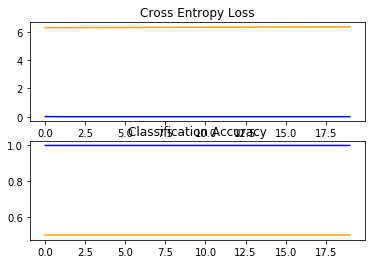

In [0]:
# model: vgg transfer learning with saved params
model_vgg_transfer = main_transfer_saved(SGD(lr=0.001, momentum=0.9), epochs=20)

with open("model_vgg_transfer", "wb") as f:
    pickle.dump(model_vgg_transfer.history, f)

## VGG16

Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 

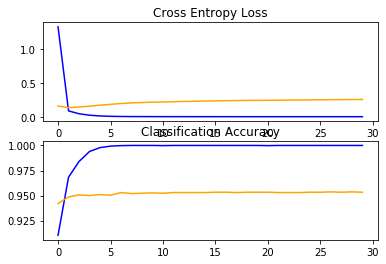

In [0]:
# model: vgg transfer learning
model_vgg_transfer = main("vgg-transfer", SGD(lr=0.001, momentum=0.9), epochs=30)

with open("model_vgg_transfer", "wb") as f:
    pickle.dump(model_vgg_transfer.history, f)

## Resnet50

Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
94773248/94765736 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75,

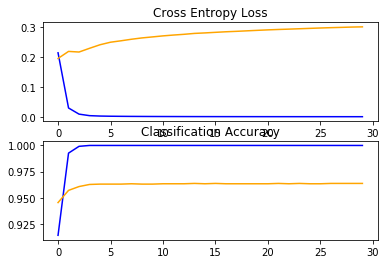

In [0]:
# model: resnet transfer learning
model_resnet_transfer = main("resnet50-transfer", SGD(lr=0.001, momentum=0.9), epochs=30)

with open("model_resnet_transfer", "wb") as f:
    pickle.dump(model_resnet_transfer.history, f)

## MobileNet

Found 6000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


/tensorflow-2.1.0/python3.6/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

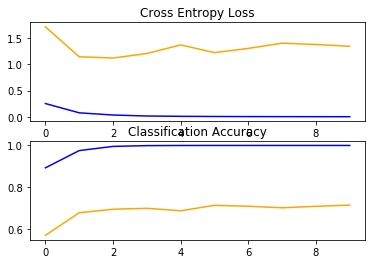

In [0]:
# model: mobilenet transfer learning
model_mobile_v2_transfer = main("mobilenet-transfer", SGD(lr=0.001, momentum=0.9), epochs=10)

with open("model_mobilenet_transfer", "wb") as f:
    pickle.dump(model_mobile_v2_transfer.history, f)

Now, you should change the model above so that the vgg16 is only run before, and you should store the features extracted by vgg16 in memory in order to train the last layers of the network.

In Keras, you can set "trainable" attribute for any layer or model. You should traverse vgg16, and try to set the trainable parameter to False before block5, and from block5 forward, it should be set to True.

You should also try to use resnet50 and mobilenetv2.

Report the best results you obtained, and plot the loss and accuracy of your experiments.

# Visualizing What the Network is Learning

In this final part of the lab you will plot what the network is learning.

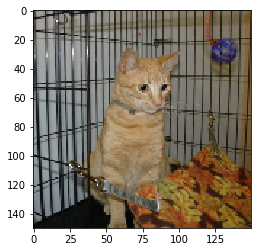

In [4]:
%tensorflow_version 1.x

from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras.models import Model

import random

img_file = random.choice(train_cats)
img  = load_img(img_file, target_size=(150, 150))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)

x /= 255.

plt.imshow(x[0])
plt.show()

In [7]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

o = vgg16.predict(x)

o.shape





58892288/58889256 [==============================] - 1s 0us/step








(1, 4, 4, 512)

(1, 150, 150, 64)


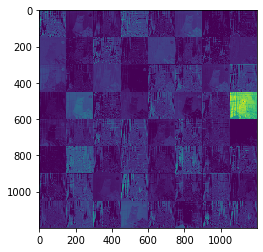

In [8]:
import numpy as np

outputs = [layer.output for layer in vgg16.layers[1:]]

vgg16_to_plot = Model(inputs=vgg16.inputs, outputs=outputs)

o = vgg16_to_plot.predict(x)

print(o[0].shape)

tiled_img = o[0][0,:,:].reshape(150,150,8,8)

full_img = np.transpose(tiled_img, [2,0,3,1]).reshape(150*8, 150*8)

plt.imshow(full_img)
plt.show()

In this exercise, plot the filters on the image _img_.

(?, 9, 9, 512) 0
(?, 9, 9, 512) 10
(?, 9, 9, 512) 20
(?, 9, 9, 512) 30
(?, 9, 9, 512) 40
(?, 9, 9, 512) 50
(?, 9, 9, 512) 60
(?, 9, 9, 512) 70
(?, 9, 9, 512) 80
(?, 9, 9, 512) 90
(?, 9, 9, 512) 100
(?, 9, 9, 512) 110
(?, 9, 9, 512) 120
(?, 9, 9, 512) 130
(?, 9, 9, 512) 140
(?, 9, 9, 512) 150


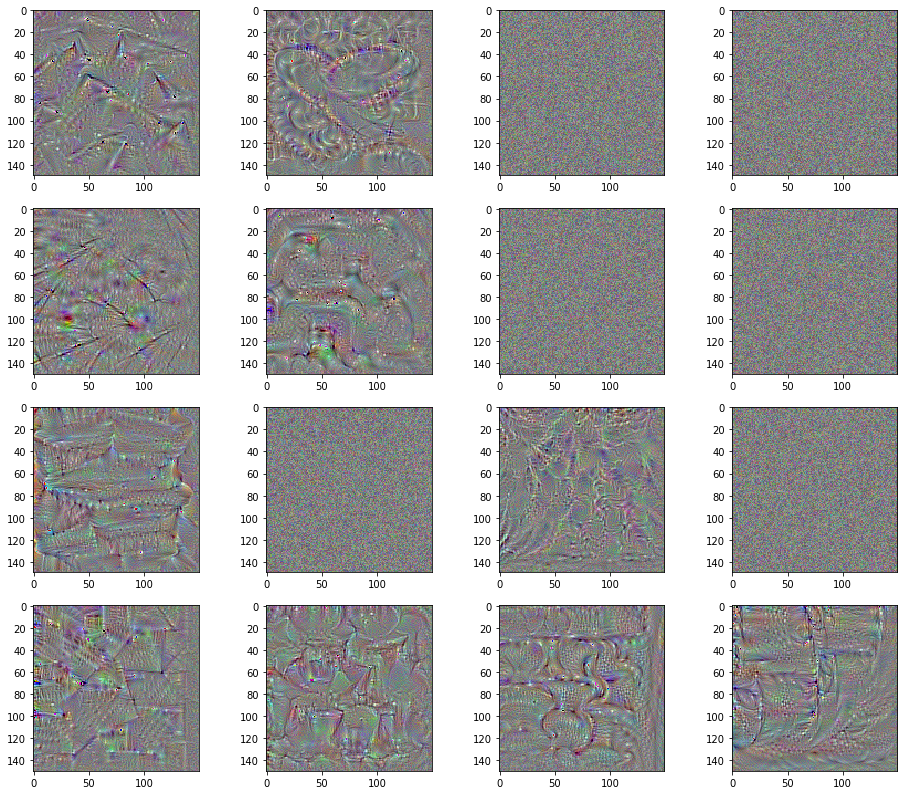

In [35]:
import keras.backend as K


def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 256
    x = np.clip(x, 0, 256).astype("uint8")
    
    return x

def plot_weights_for_layer(model, layer_name, filter_index):
    layer_output = model.get_layer(layer_name).output
    print(layer_output[:, :, :].shape, filter_index)
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.inputs)[0]

    grads /= K.sqrt(K.mean(K.square(grads)) + 1e-5)
    
    iterate = K.function(model.inputs, [loss, grads])
    
    loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])
    
    input_img_data = (np.random.rand(1, 150, 150, 3) * 20 + 128.)
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)


fig, axs = plt.subplots(4, 4, figsize=(16, 14))
for row in range(4):
    for col in range(4):
        n = (row * 4 + col) * 10

        img = plot_weights_for_layer(vgg16, "block5_conv2", n)
        axs[row][col].imshow(img)
        
plt.show()

Now, try to find some filters that may detect some interesting features like lines.

(?, 18, 18, 512) 0
(?, 18, 18, 512) 10
(?, 18, 18, 512) 20
(?, 18, 18, 512) 30


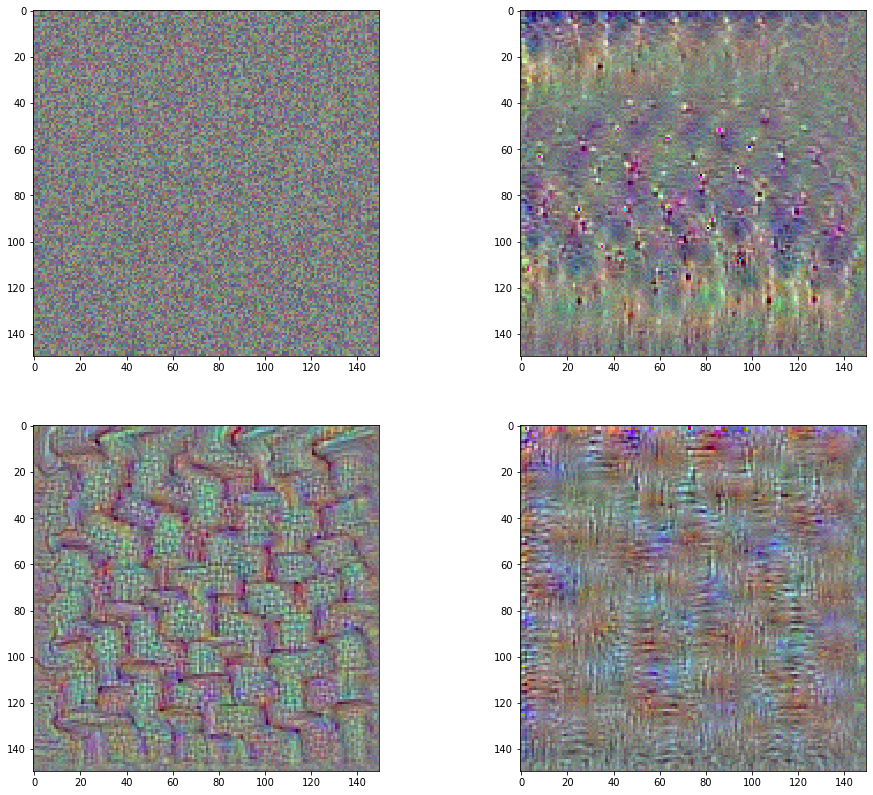

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for row in range(2):
    for col in range(2):
        n = (row * 2 + col) * 10

        img = plot_weights_for_layer(vgg16, "block4_conv3", n)
        axs[row][col].imshow(img)
        
plt.show()

(?, 37, 37, 256) 0
(?, 37, 37, 256) 10
(?, 37, 37, 256) 20
(?, 37, 37, 256) 30


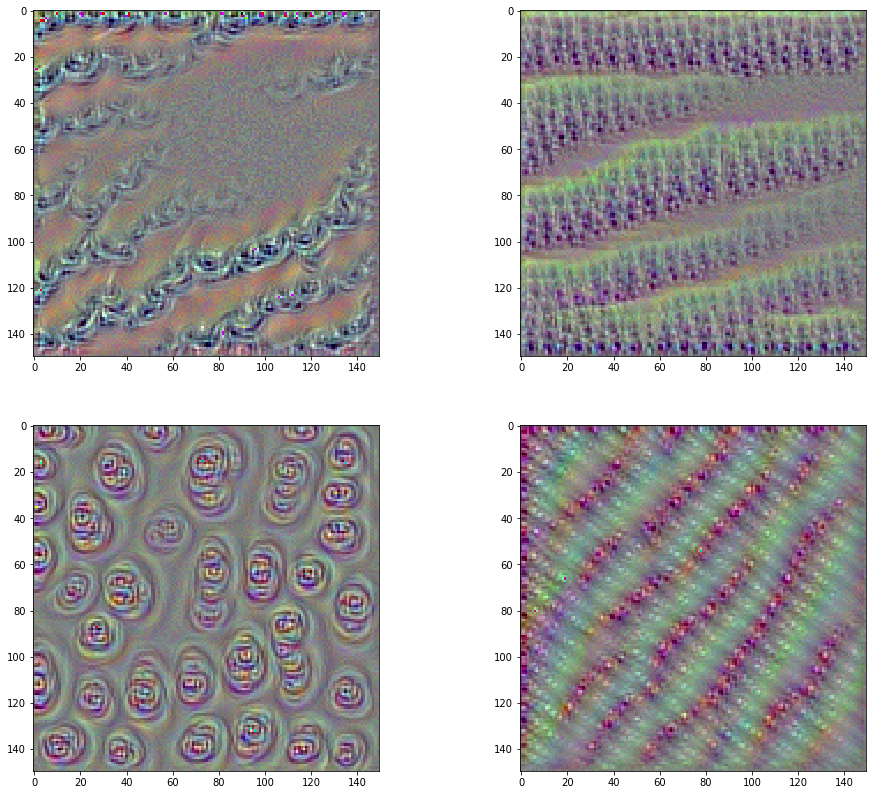

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for row in range(2):
    for col in range(2):
        n = (row * 2 + col) * 10

        img = plot_weights_for_layer(vgg16, "block3_conv3", n)
        axs[row][col].imshow(img)
        
plt.show()

(?, 75, 75, 128) 0
(?, 75, 75, 128) 10
(?, 75, 75, 128) 20
(?, 75, 75, 128) 30


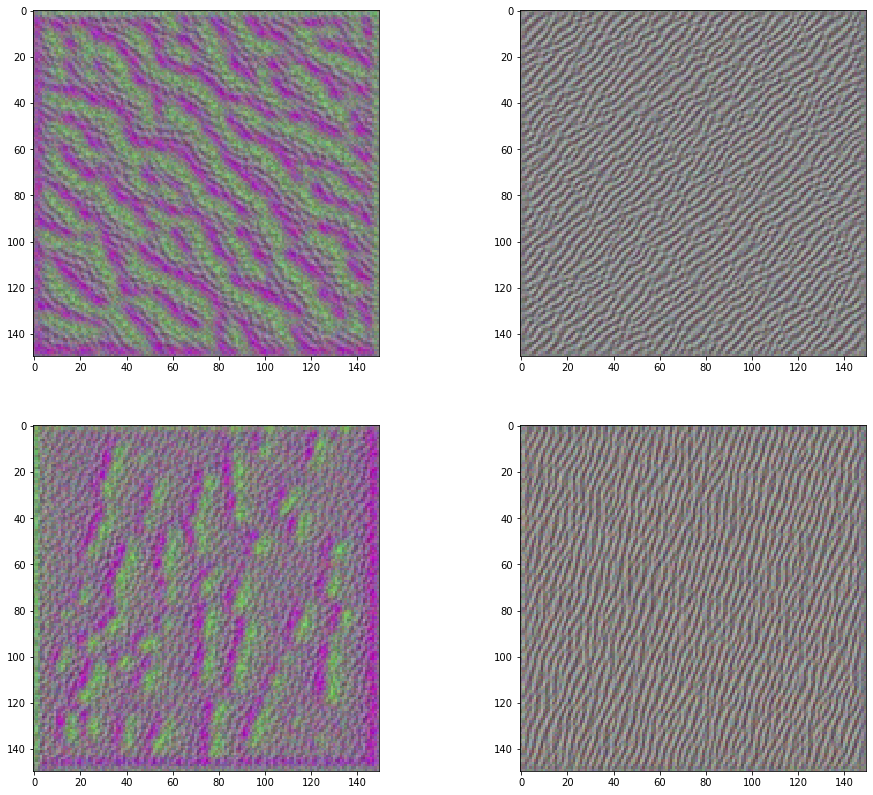

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for row in range(2):
    for col in range(2):
        n = (row * 2 + col) * 10

        img = plot_weights_for_layer(vgg16, "block2_conv2", n)
        axs[row][col].imshow(img)
        
plt.show()

(?, 150, 150, 64) 0
(?, 150, 150, 64) 12
(?, 150, 150, 64) 24
(?, 150, 150, 64) 36


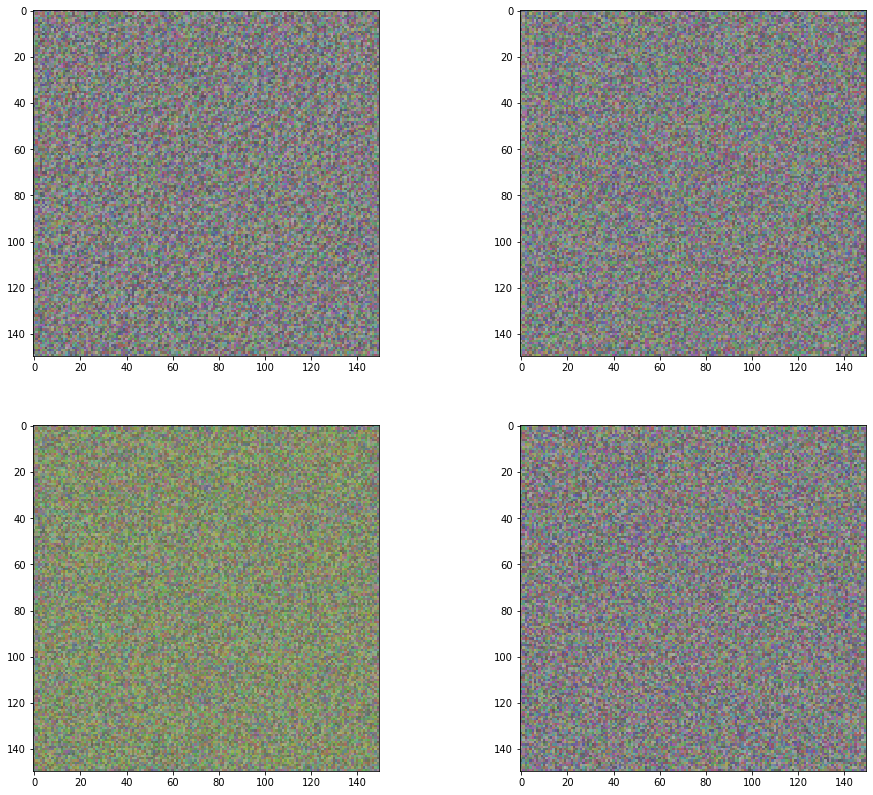

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for row in range(2):
    for col in range(2):
        n = (row * 2 + col) * 12

        img = plot_weights_for_layer(vgg16, "block1_conv2", n)
        axs[row][col].imshow(img)
        
plt.show()